# Implementing Deep Neuronal Networks Motivated by Ordinary Differential Equations

In [1]:
# experiment number
cycle = 1
# number of classes: 10=CIFAR10, 100=CIFAR100, '10b'=STL10, 3=Oxford IIIt Pet, 20=bdd100k
num_classes = 3
# train, test_noise, test_adversarial_attack, test_blur: boolean: test routines to run
train=True
test_noise=False
test_adversarial_attack=False
test_blur=False

**Load necessary packages**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# source: www.tensorflow.org
import tensorflow as tf
if int(tf.__version__[0]) == 1:
    raise NotImplementedError('only tensorflow 2 supported')

import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks, constraints, regularizers, optimizers, datasets
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import preprocessing
from tensorflow.python.ops import nn_ops, nn
import tensorflow_datasets as tfds

# source: https://cs.stanford.edu/~acoates/stl10/
from STL10 import stl10_input

sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)


## Prepare Data

**Load, normalize and show data**

In [3]:
# source: https://www.tensorflow.org/tutorials/images/segmentation
def load_oxford(datapoint, image_size=64):
    '''
    Load the Oxford-IIIT Pet Dataset from tensorflow_datasets and generates data with labels.
    # Arguments:
    datapoint: tensorflow dataset datapoint
    image_size: int; resize images to dimension (image_size, image_size)
    # Returns:
    input_image, input_mask: tensorflow dataset splitted into input/images and labels/masks
    '''
    # resize images
    input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (image_size, image_size))
    # normalize
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [85]:
# source: https://www.tensorflow.org/tutorials/images/segmentation
def display(display_list):
    '''
    Showes an image, it's true mask and the predcited mask for the Oxford-IIIT Pet Dataset.
    # Arguments:
    display_list: list of 3D-tensor; consisting of input image, true mask and a predicted mask.
    '''
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    return

In [108]:
# source: https://www.tensorflow.org/tutorials/images/segmentation
def show_predictions(dataset, model, num_of_pred=1):
    '''
    Does prediction on a dataset with a model and plots the images and the masks for the Oxford-IIIT Pet Dataset.
    # Arguments:
    dataset: tensorflow dataset.
    model: keras model; model which does the prediction.
    num_of_pred: int; number of predictions to make.
    '''
    for image, mask in dataset.take(num_of_pred):
        pred_mask = model.predict(image)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        display([image[0], mask[0], pred_mask[0]])
    return

In [6]:
def ConvertToRGBImage(labels):
    '''
    Converts the labels of bdd100k into an RGB-image.
    # Arguments:
    labels: numpy array; label for each pixel in an image.
    # Returns:
    RGB-image
    '''
    # array of colours
    colours = [(128, 64, 128), (244, 35, 232), (70, 70, 70), (102, 102, 156),
               (190, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0),
               (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60),
               (255, 0, 0), (0, 0, 142), (0, 0, 70), (0, 60, 100), (0, 80, 100),
               (0, 0, 230), (119, 11, 32), (0, 0, 0)]
    # create image from label
    img = np.zeros((labels.shape[0], labels.shape[1], 3))
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            img[i,j,:] = colours[labels[i,j,0]]
    return img/255.

In [7]:
def load_bdd_data(x_folder, y_folder, resize_factor=3):
    '''
    Loades the bdd100k-dataset.
    # Arguments:
    x_folder: string; path to input-images.
    y_folder: string; path to labels.
    resize_factor: int; rescale size of images by this factor.
    # Returns:
    two numpy arrays consisting of images and labels.
    '''
    x, y = [], []
    count = 0
    for file in os.listdir(x_folder):
        # load image
        img = cv2.imread(x_folder+file)   
        mask = cv2.imread(y_folder+file[:-4]+'_train_id.png')
        # resize image and labels by deleting every second row and column
        # thus pixel-wise labels stay the same 
        for i in range(resize_factor):
            img = np.delete(img, np.s_[::2], 0)
            img = np.delete(img, np.s_[::2], 1)
            mask = np.delete(mask, np.s_[::2], 0)
            mask = np.delete(mask, np.s_[::2], 1)
        # append image to array
        x.append(img)
        y.append(mask[:,:,0])
        del img, mask
        count +=1
        # computer without GPU support needs to much time to load all images
        if count == 10 and not tf.config.list_physical_devices('GPU'):
            break
    # convert to numpy array
    return np.array(x), np.array(y)

In [8]:
def load_data(num_classes, batch_size=125):
    '''
    Load training and test data depending on the number of classes.
    # Arguments:
    num_classes: int/string; number of classes: 10=CIFAR10, 100=CIFAR100, '10b'=STL10, 3=Oxford IIIt Pet, 20=bdd100k.
    batch_size: int; size of the batch, only needed for Oxford IIIt Pet. For other datasets it is specified later.
    # Returns:
    (x_train, y_train), (x_test, y_test): numpy array; training and test data.
    or 
    train_dataset, test_dataset, info: parts of a tensorflow dataset (Oxford IIIt Pet).
    '''
    if num_classes == '10b': 
        # STL10
        directory = './data/stl10_binary'
        # download data
        if not os.path.exists(directory):
            stl10_input.download_and_extract()

        # read the data (train and test set)
        x_train = stl10_input.read_all_images(directory+'/train_X.bin')
        y_train = stl10_input.read_labels(directory+'/train_y.bin')
        x_test = stl10_input.read_all_images(directory+'/test_X.bin')
        y_test = stl10_input.read_labels(directory+'/test_y.bin')

        # reshape array to class vectors, convert class number from (1-10) to (0-9)
        y_test = np.reshape(y_test, (y_test.shape[0], 1)) - 1
        y_train = np.reshape(y_train, (y_train.shape[0], 1)) - 1

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)
        
    elif num_classes == 3:
        # segmentation task
        # download data
        dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
        
        # read the data (train and test set)
        train = dataset['train'].map(load_oxford, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        test = dataset['test'].map(load_oxford)
        
        # cache the data with batch_size
        train_dataset = train.cache().shuffle(1000).batch(batch_size).repeat()
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        test_dataset = test.batch(batch_size)
        return train_dataset, test_dataset, info
        
    elif num_classes == 20:
        x_train_folder = 'data/bdd100k/seg/images/train/'
        y_train_folder = 'data/bdd100k/seg/labels/train/'    
        x_test_folder = 'data/bdd100k/seg/images/val/'
        y_test_folder = 'data/bdd100k/seg/labels/val/'
        
        # load data
        x_train, y_train = load_bdd_data(x_train_folder, y_train_folder)
        x_test, y_test = load_bdd_data(x_test_folder, y_test_folder)
        
        # normalize labels to range 0-20
        y_train[y_train == 255] = 19
        y_test[y_test == 255] = 19
        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
        
    elif num_classes > 1:
        # classification problem
        if num_classes == 10:
            # split between train and test sets
            (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        elif num_classes == 100:
            # split between train and test sets
            (x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()            
        else:
            raise ValueError('bad number of classes')
        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
        
    else:
        raise ValueError('bad number of classes')
        
    return (x_train, y_train), (x_test, y_test) 

In [9]:
def normalize(x_train, x_test, subtract_mean=True):
    '''
    Normalize training and test data.
    # Arguments:
    x_train, x_test: numpy array; images with RGB/grey-scale values between 0 and 255.
    subtract_mean: boolean; whether the mean should be subtracted from the normalized images.
    # Returns:
    x_train, x_test: numpy array; normalized images.
    '''
    # normalize to range 0-1
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    mean = 0
    if subtract_mean:
        # subtract mean to get better classification results
        mean = np.mean(x_train, axis=0)
        x_train -= mean
        x_test -= mean
    return x_train, x_test, mean

## Define Regularization


Define regularizer for the kernel of the convolutional layers, since for ODE inspired networks it is necassary that the convolutional operator K changes smooth enough to get stable networks.

$R(K) = \alpha_1 s \int_0^T \phi_\tau(\partial_tK(t))dt + \frac{\alpha_2}{2} \left( \int_0^T \lVert K(t) \rVert^2 dt \right)$

$\phi_\tau(x) = \sqrt{x^2+\tau}$

The parameter $s$ (steps) is refering to the number of evaluations points for one time step.
First term is a smoothed L1 regularization factor, which can be seen as total variation penalty in time that favors piecewise constant dynamics (Haber and Ruthotto). They also apply L2 regularization to the classification layer, which is implemented directly on the classifier.

In [10]:
class NoKernel(object):
    '''Object imitating an empty kernel, so no kernel is used as reference.'''
    kernel = 0
    
    def get_config():
        return {'No kernel reference.'}

In [11]:
class SmoothL2(regularizers.Regularizer):
    """Regularizer for smoothing weights between adjacent layers.
    # Arguments
        last_conv_layer: keras kernel object or NoKernel object;
                        - layer kernel used for regularization.
                        - for NoKernel a normal L2 regularization is calculated.
        a1: float >0; smoothed L1 regularization factor between two layers.
        a2: float >0; L2 regularization factor.
        steps: int >0; factor depending on number of evalutation points for one time step.
    # Returns
        regularization for keras implementation
    """
    def __init__(self, last_conv_layer=NoKernel, a1=2.e-4, a2=2.e-4, tau=1.e-3, steps=1):
        self.last_conv_layer = last_conv_layer
        self.a1 = K.cast_to_floatx(a1)
        self.a2 = K.cast_to_floatx(a2)
        self.tau = K.cast_to_floatx(tau)
        self.steps = steps

    def __call__(self, x):
        phi = K.sqrt(K.square(x-self.last_conv_layer.kernel)+self.tau)
        regularization = self.a1 * self.steps * K.sum(phi)
        regularization += self.a2/2. * K.sum(K.square(x))
        return regularization

    def get_config(self):
        return {'a1': float(self.a1),
                'a2': float(self.a2),
                'tau': float(self.tau),
                'steps': int(self.steps)
               }

## Define Layers


Each type of layer is defined as a function which takes the following arguments:
- y_n: 4D-Tensor; output of the layer before.
- filters: int; number of filters for convolutional layer.
- regularizer_param: [[keras layer, keras layer], float >=0, float >=0]; layer object needed for calculation of the difference between two kernels of adjacent layers (two objects for hamiltonian networks), when no regularization should be applied use NoKernel Class. The two float values specify the scaling factors of the regularization (a1, a2, see SmoothL2 below for details)
- kernel_initializer: string; name of keras kernel initializer.
- kernel_constraint: keras constraint; constraint for kernel of convolutional layers.

The functions returns an output tensor for Keras functional API and a list of keras layers (their kernel is later used for regularization).

**Standard ResNet**

$F(\theta, Y) = −K_2(\theta)^T \sigma(N_{bn}((K_1(\theta)Y, \theta)))$

In [12]:
# define a ResNet layer as baseline model
def res_net_layer(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint=None):
    kernel_regularizer = regularizers.l2(regularizer_param[2]) #a2, L2 regularization
    conv1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                          kernel_initializer=kernel_initializer,
                          kernel_regularizer=kernel_regularizer)(y_n)
    norm = layers.BatchNormalization()(conv1)
    relu = layers.ReLU()(norm)
    conv2 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                          kernel_initializer=kernel_initializer,
                          kernel_regularizer=kernel_regularizer)(relu)
    
    # add layer relu and identity ouput together
    next_y_n = layers.add([y_n, conv2])
    return next_y_n, [NoKernel, NoKernel]

**Normalization Layer**

$N_{tv}(y) = \text{diag} \left( \frac{1}{A^T \sqrt{A(y^2)+\epsilon}} \right)y$

- $y \in \mathbb{R}^n$ is one sample
- $A \in \mathbb{R}^{n /c \times n}$ computes the sum over all channels $c$ for each pixel
- the square, square root, and the division are defined component-wise
- $0 < \epsilon \ll 1$ is fixed

Leads to $N_{tv}(p_i) = \frac{1}{\sqrt{(\sum_c{ p_{i,c}^2}) + \epsilon}}p_i$ for $p_i$ beeing one pixel with $c$ channels. Introduced by Eldad Haber, Lars Ruthotto in Deep Neural Networks Motivated by Partial Differential Equations.

In [13]:
class NormalizationLayer(layers.Layer):
    '''
    Normalization layer motivated by total variation denoising.
    # Arguments:
    epsilon: float >0; normalization smoothness parameter.
    '''
    def __init__(self, epsilon=1.e-3, use_bias=True, **kwargs):
        super(NormalizationLayer, self).__init__(**kwargs)
        self.epsilon = K.cast_to_floatx(epsilon)
        self.use_bias = use_bias
        
    def build(self, input_shape):
        self.output_dim = input_shape
        # Create trainable weights and biases for each channel
        self.kernel = self.add_weight(name='kernel', shape=(input_shape[-1],), initializer='ones', trainable=True)
        self.bias = self.add_weight(name='bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(NormalizationLayer, self).build(input_shape)
        
    def call(self, y):
        # computes the square of y and then sum over all channels for each pixel
        x = tf.math.reduce_sum(tf.math.square(y), axis=3)
        # computes reciprocal of square root of x+epsilon element-wise
        x = tf.math.rsqrt(x+self.epsilon)
        # reshapes x, so scaling factor will be applied to each channel
        x = tf.stack([x]*self.output_dim[-1], axis=3)
        # multiply tensors element-wise
        x = tf.math.multiply(x, self.kernel)
        if self.use_bias:
            x += self.bias
        y = tf.math.multiply(x, y) 
        return y
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        return {'name': self.name,
                'trainable': self.trainable,
                'epsilon': float(self.epsilon),
                'kernel_size': self.kernel.shape,
                'use bias': self.use_bias,
               }

**Symmetric Layer**

$F_{sym}(\theta, Y) = −K(\theta)^T \sigma(N_{tv}((K(\theta)Y, \theta)))$

Introduced by Eldad Haber, Lars Ruthotto in Deep Neural Networks Motivated by Partial Differential Equations.

In [14]:
class TiedConv2D(layers.Conv2D):
    '''
    Define convolutional layer which uses the negative, transposed weights from a specified convolutional layer.
    # Arguments:
    tied_to: keras layer object; layer's kernel will be used for this class.
    '''
    def __init__(self, filters, kernel_size, tied_to, **kwargs):
        super(TiedConv2D, self).__init__(filters, kernel_size, **kwargs)
        self.tied_to = tied_to
        self.filters = filters
        self.kernel_size = kernel_size
        self.rank = tied_to.rank
        self.strides = tied_to.strides
        self.padding = tied_to.padding
        self.data_format = tied_to.data_format
        self.dilation_rate = tied_to.dilation_rate
        self.input_spec = layers.InputSpec(ndim=self.rank + 2)
        
    def build(self, input_shape):
        # the following remains of the original code for Conv2D
        input_shape = tf.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        kernel_shape = self.kernel_size + (input_channel, self.filters)
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        # own code
        # transposed, negative kernel
        transposed = K.permute_dimensions(self.tied_to.kernel, (1,0,2,3))
        self.kernel = tf.math.negative(transposed)
        
        # the following remains of the original code for Conv2D
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec
        self.input_spec = layers.InputSpec(ndim=self.rank + 2,
                                               axes={channel_axis: input_dim})   
        self._build_conv_op_input_shape = input_shape
        self._build_input_channel = input_channel
        self._padding_op = self._get_padding_op()
        # self._conv_op_data_format = conv_utils.convert_data_format(self.data_format, self.rank + 2) 
        # function returns for data_format=channels_last, rank=2: "NHWC" 
        self._conv_op_data_format = "NHWC" 
        self._convolution_op = nn_ops.Convolution(input_shape,
                                                  filter_shape=self.kernel.shape,
                                                  dilation_rate=self.dilation_rate,
                                                  strides=self.strides,
                                                  padding=self._padding_op,
                                                  data_format=self._conv_op_data_format)   
        self.built = True 

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            return 1
        else:
            return -1

    def _get_padding_op(self):
        if self.padding == 'causal':
            op_padding = 'valid'
        else:
            op_padding = self.padding
        if not isinstance(op_padding, (list, tuple)):
            op_padding = op_padding.upper()
        return op_padding

In [15]:
# defines symmetric layer as defined by Haber and Ruthotto
# will be used by all following layers
def layer_symmetric(inputs, filters, kernel_regularizer, kernel_initializer, kernel_constraint, reuse=False):
    '''
    Symmetric layer defined by Haber and Ruthotto. 
    # Arguments:
    inputs: tensor; output of the last layer.
            or list defining the shape of the input when reuse=True
    filters: int >0; number of convolutional filters.
    kernel_regularizer: keras regularizer object.
    kernel_initializer: string; name of keras kernel initializer.
    kernel_constraint: keras constraint object; constraint for kernel of convolutional layers.
    reuse: boolean; if the layer should be used again, a keras model is returned instead of the output-tensor.
    # Returns:
    output tensor for keras functional API, convolutional layer (kernel used for regularization)
    '''
    conv_layer = layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer, 
                         kernel_constraint=kernel_constraint)

    conv = conv_layer(inputs)
    norm = NormalizationLayer()(conv)
    relu = layers.ReLU()(norm)
    output = TiedConv2D(conv_layer.filters, conv_layer.kernel_size, conv_layer)(relu)
    # returning an instance of the convolutional layer if wanted
    if reuse:
        layer_instance = Model(inputs=inputs, outputs=output)     
        return layer_instance, conv_layer
    return output, conv_layer

**Forward Euler**

$Y_{n+1} = Y_n + \delta_t F_{sym}(\theta(t_n),Y_n)$ with fixed step size $\delta_t = 1$ 

In [16]:
# returns a layer motivated by the forward euler method
def layer_euler(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # F(y_n)
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    k1, last_conv_layer = layer_symmetric(y_n, filters, kernel_regularizer, kernel_initializer, kernel_constraint)

    # add layer ouput and identity together
    next_y_n = layers.add([y_n, k1])
    return next_y_n, [last_conv_layer, NoKernel]

**Stabilized Euler**

Composition of two euler steps with Lebedev's Realization

$g_i = g_{i-1} + 1/2 F_{sym}(g_{i-1})$

$g_{i+1}^* = g_{i} + 1/2 F_{sym}(g_{i})$

$g_{i+1} = g_{i+1}^* +((g_{i+1}^*-g_i)-(g_i-g_{i-1}))$

In [17]:
# defines a layer motivated by the stabilized euler method
def layer_stabilized_euler(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint):    
    # g_i
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    fg1, last_conv_layer = layer_symmetric(y_n, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    mg1 = layers.Lambda(lambda x: x * 1/2)(fg1)
    g1 = layers.add([y_n, mg1])
    
    # g*_i+1
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    fg2_, last_conv_layer = layer_symmetric(g1, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    mg2_ = layers.Lambda(lambda x: x * 1/2)(fg2_)
    g2_ = layers.add([g1, mg2_])
    
    # g_i+1
    x1 = layers.subtract([g2_, g1])
    x2 = layers.subtract([g1, y_n])
    x3 = layers.subtract([x1, x2])
    g2 = layers.add([g2_, x3])

    return g2, [last_conv_layer, NoKernel]

**Runge-Kutta of Order s=2 (Heun's Method)** 

$k_i = F_{sym}(t_n+c_i h, y_n+h\sum_{j=1}^{i-1}a_{ij}k_j)$

$y_{n+1} = y_n + h \sum_{i=1}^s b_i k_i$


$A=\left( \begin{array}{rr}
0 & 0 \\                                              
1 & 0 \\                                           
\end{array}\right)$,
$b=\left( \begin{array}{r}
1/2 \\                                              
1/2 \\                                           
\end{array}\right)$,
$h = 1$

In [18]:
# defines a layer motivated by Runge-Kutta of order 2
def layer_rk_order2(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # F(y_n)
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    k1, last_conv_layer = layer_symmetric(y_n, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    
    # add layer ouput and identity together
    added = layers.add([y_n, k1])
    
    # apply F again
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    k2, last_conv_layer = layer_symmetric(added, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    
    # multiply with weights from Runge-Kutta second order then add together with identity
    mk1 = layers.Lambda(lambda x: x * 1/2)(k1)
    mk2 = layers.Lambda(lambda x: x * 1/2)(k2)
    next_y_n = layers.add([y_n, mk1, mk2])
    return next_y_n, [last_conv_layer, NoKernel]

**Runge-Kutta of Order s=4 (Classical Method)** 

$k_i = F_{sym}(t_n+c_i h, y_n+h\sum_{j=1}^{i-1}a_{ij}k_j)$

$y_{n+1} = y_n + h \sum_{i=1}^s b_i k_i$


$A=\left( \begin{array}{rrrr}
0 & 0 & 0 & 0 \\                                              
1/2 & 0 & 0 & 0 \\  
0 & 1/2 & 0 & 0 \\  
0 & 0 & 1 & 0 \\  
\end{array}\right)$,
$b=\left( \begin{array}{r}
1/3 \\                                              
1/6 \\  
1/6 \\                                              
1/3 \\  
\end{array}\right)$,
$h = 1$

In [19]:
# defines a layer motivated by Runge-Kutta of order 4
def layer_rk_order4(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # F(y_n)
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    k1, last_conv_layer = layer_symmetric(y_n, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
  
    # add 1/2*k1 and identity together
    mk1 = layers.Lambda(lambda x: x * 1/2)(k1)
    added = layers.add([y_n, mk1])
    
    # create an instance of symmetric layer, so it can be used multiple times
    shape = added.get_shape().as_list() # shape has to be a list of ints
    inputs = layers.Input(shape=shape[1:])
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    layer_instance, last_conv_layer = layer_symmetric(inputs, filters, kernel_regularizer, kernel_initializer, kernel_constraint, reuse=True)
    
    # apply F again
    k2 = layer_instance(added)

    # add 1/2*k2 and identity together
    mk2 = layers.Lambda(lambda x: x * 1/2)(k2)  
    added_2 = layers.add([y_n, mk2])
    
    # apply F again (same time step as before, thus reuse layer instance)
    k3 = layer_instance(added_2)

    # add k3 and identity together
    added_3 = layers.add([y_n, k3])
    
    # apply F again
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    k4, last_layer = layer_symmetric(added_3, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
  
    # multiply with weights from Runge-Kutta fourth order then add together with identity
    bk1 = layers.Lambda(lambda x: x * 1/6)(k1)
    bk2 = layers.Lambda(lambda x: x * 1/3)(k2)
    bk3 = layers.Lambda(lambda x: x * 1/3)(k3)
    bk4 = layers.Lambda(lambda x: x * 1/6)(k4)
    next_y_n = layers.add([y_n, bk1, bk2, bk3, bk4])
    return next_y_n, [last_conv_layer, NoKernel]

**Symplectic Euler** 

$Y_{n+1} = Y_n − h F_{sym}(Z_n)$

$Z_{n+1} = Z_n + h F_{sym}(Y_{n+1})$

$h = 1$

In [20]:
# defines a layer motivated by hamiltonian discretization of order 1
def layer_symplectic_euler(inputs, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # split input into two slices of the same size
    filters = int(filters/2)
    y_n = layers.Lambda(lambda x: x[:,:,:,filters:])(inputs)
    z_n = layers.Lambda(lambda x: x[:,:,:,:filters])(inputs)
    
    # F(z_n)
    kernel_regularizer_1 = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    p1, last_conv_layer_1 = layer_symmetric(z_n, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
    
    # subtract F(z_n) from y_n to get y_n+1
    next_y_n = layers.subtract([y_n, p1])
    
    # F(y_n+1)
    kernel_regularizer_2 = SmoothL2(regularizer_param[0][1], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    q2, last_conv_layer_2 = layer_symmetric(next_y_n, filters, kernel_regularizer_2, kernel_initializer, kernel_constraint)
    
    # add F(y_n+1) and z_n together to get z_n+1
    next_z_n = layers.add([z_n, q2])
    
    # merge next_y_n and next_z_n together
    output = layers.concatenate([next_y_n, next_z_n])
    return output, [last_conv_layer_1, last_conv_layer_2]

**Autonomous Symplectic Euler** 

Same as symplectic Euler but without time depending function $F_{sym}$. Thus reusing one layer with the same weights for every evaluation point. 

In [21]:
# defines a layer motivated by hamiltonian discretization of order 1 for autonomous hamiltonian system
def layer_symplectic_euler_autonomous(inputs, filters, regularizer_param, kernel_initializer, kernel_constraint, time_steps=3):
    kernel_regularizer = regularizers.l2(regularizer_param[2]) #a2, L2 regularization
    
    # split input into two slices of the same size
    filters = int(filters/2)
    y_n = layers.Lambda(lambda x: x[:,:,:,filters:])(inputs)
    z_n = layers.Lambda(lambda x: x[:,:,:,:filters])(inputs)
    
    # create layer instances for p and q
    # p
    shape = z_n.get_shape().as_list() # shape has to be a list of ints
    inputs = layers.Input(shape=shape[1:])
    p_layer_instance, last_conv_layer = layer_symmetric(inputs, filters, kernel_regularizer, kernel_initializer, kernel_constraint, reuse=True)
    # q
    shape = y_n.get_shape().as_list() # shape has to be a list of ints
    inputs = layers.Input(shape=shape[1:])
    q_layer_instance, last_conv_layer = layer_symmetric(inputs, filters, kernel_regularizer, kernel_initializer, kernel_constraint, reuse=True)
    
    # loop over time steps
    for i in range(time_steps):    
        # F(z_n)
        p1 = p_layer_instance(z_n)

        # subtract F(z_n) from identity
        y_n = layers.subtract([y_n, p1])

        # F(y_n+1)
        q2 = q_layer_instance(y_n)

        # add F(y_n+1) and identity together
        z_n = layers.add([z_n, q2])
  
    # merge next_y_n and next_z_n together
    output = layers.concatenate([y_n, z_n])
    return output, [NoKernel, NoKernel]

**Strömer-Verlet** 

$Q_0 = z_n$, $P_1 = y_n$

for $i$, $\dots$, $s$ do: $Q_i = Q_{i-1} + h b_i F_{sym}(P_i)$, $P_{i+1} = P_{i} - h {b'}_i F_{sym}(Q_i)$

$z_{n+1} = Q_s$, $y_{n+1} = P_{s+1}$

$b=\left( \begin{array}{r}
0\\                                              
1\\
\end{array}\right)$,
$b'=\left( \begin{array}{r}
1/2\\                                              
1/2\\
\end{array}\right)$,
$h = 1$

In [22]:
# defines a layer motivated by hamiltonian discretization of order 2
def layer_stoermer_verlet(inputs, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # split input into two slices of the same size
    filters = int(filters/2)
    p_0 = layers.Lambda(lambda x: x[:,:,:,filters:])(inputs)
    q_0 = layers.Lambda(lambda x: x[:,:,:,:filters])(inputs)
    
    # F(q_0) #t+1/2h
    kernel_regularizer_1 = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    fq_0, last_conv_layer_1 = layer_symmetric(q_0, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
 
    # add -h/2F(z_n) and identity together
    mfq_0 = layers.Lambda(lambda x: -1/2*x)(fq_0)
    P1 = layers.add([p_0, mfq_0])

    # F(q_0) #t+h
    kernel_regularizer_1 = SmoothL2(last_conv_layer_1, a1=regularizer_param[1], a2=regularizer_param[2], steps=2)
    fq_0, last_conv_layer_1 = layer_symmetric(q_0, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)

    # add hF(P2) and identity together
    mfq_0 = layers.Lambda(lambda x: -1/2*x)(fq_0)
    P2 = layers.add([P1, mfq_0])
    
    # F(P2)
    kernel_regularizer_2 = SmoothL2(regularizer_param[0][1], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    fP2, last_conv_layer_2 = layer_symmetric(P2, filters, kernel_regularizer_2, kernel_initializer, kernel_constraint)
  
    # add -h/2F(q2) and identity together
    Q3 = layers.add([q_0, fP2])
    
    # merge next_y_n and next_z_n together
    output = layers.concatenate([P2, Q3])
    return output, [last_conv_layer_1, last_conv_layer_2]

**Partioned Runge-Kutta Stabilzed 3rd-Order** 

$Q_0 = z_n$, $P_1 = y_n$

for $i$, $\dots$, $s$ do: $Q_i = Q_{i-1} + h b_i F_{sym}(P_i)$, $P_{i+1} = P_{i} - h {b'}_i F_{sym}(Q_i)$

$z_{n+1} = Q_s$, $y_{n+1} = P_{s+1}$


$b=\left( \begin{array}{r}
1/3 \\                                              
(\sqrt{13}+3)/6 \\  
(3-\sqrt{13})/6 \\                                              
-1/3 \\  
\end{array}\right)$,
$b'=\left( \begin{array}{r}
(13-\sqrt{13})/12 \\                                              
-1/2 \\  
(\sqrt{13}+5)/12 \\                                              
0 \\
\end{array}\right)$,
$h = 1$

In [23]:
# defines a layer motivated by hamiltonian discretization of order 3
def layer_stabilized_third_order(inputs, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # split input into two slices of the same size
    filters = int(filters/2)
    y_n = layers.Lambda(lambda x: x[:,:,:,filters:])(inputs)
    z_n = layers.Lambda(lambda x: x[:,:,:,:filters])(inputs)
    
    # Q1 = z_n + hb1 f(y_n)
    kernel_regularizer_1 = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=4)
    fy_n, last_conv_layer_1 = layer_symmetric(y_n, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
    mfy_n = layers.Lambda(lambda x: 1/3*x)(fy_n)
    q1 = layers.add([z_n, mfy_n])
    
    #P2 = y_n - hb'1 f(Q1)
    kernel_regularizer_2 = SmoothL2(regularizer_param[0][1], a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    fq1, last_conv_layer_2 = layer_symmetric(q1, filters, kernel_regularizer_2, kernel_initializer, kernel_constraint)
    mfq1 = layers.Lambda(lambda x: -(13-np.sqrt(13))/12*x)(fq1)
    p2 = layers.add([y_n, mfq1])
    
    #Q2 = Q1 + hb2 f(P2)
    kernel_regularizer_1 = SmoothL2(last_conv_layer_1, a1=regularizer_param[1], a2=regularizer_param[2], steps=4)
    fp2, last_conv_layer_1 = layer_symmetric(p2, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
    mfp2 = layers.Lambda(lambda x: (np.sqrt(13)+3)/6*x)(fp2)
    q2 = layers.add([q1, mfp2])
    
    #P3 = P2 - hb'2 f(Q2)
    kernel_regularizer_2 = SmoothL2(last_conv_layer_2, a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    fq2, last_conv_layer_2 = layer_symmetric(q2, filters, kernel_regularizer_2, kernel_initializer, kernel_constraint)
    mfq2 = layers.Lambda(lambda x: 1/2*x)(fq2)
    p3 = layers.add([p2, mfq2])
    
    #Q3 = Q2 + hb3 f(P3)
    kernel_regularizer_1 = SmoothL2(last_conv_layer_1, a1=regularizer_param[1], a2=regularizer_param[2], steps=4)
    fp3, last_conv_layer_1 = layer_symmetric(p3, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
    mfp3 = layers.Lambda(lambda x: (3-np.sqrt(13))/6*x)(fp3)
    q3 = layers.add([q2, mfp3])
    
    #P4 = P3 - hb'3 f(Q3)
    kernel_regularizer_2 = SmoothL2(last_conv_layer_2, a1=regularizer_param[1], a2=regularizer_param[2], steps=3)
    fq3, last_conv_layer_2 = layer_symmetric(q3, filters, kernel_regularizer_2, kernel_initializer, kernel_constraint)
    mfq3 = layers.Lambda(lambda x: -(np.sqrt(13)+5)/12*x)(fq3)
    p4 = layers.add([p3, mfq3])
    
    #Q4 = Q3 + hb4 f(P4)
    kernel_regularizer_1 = SmoothL2(last_conv_layer_1, a1=regularizer_param[1], a2=regularizer_param[2], steps=4)
    fp4, last_conv_layer_1 = layer_symmetric(p4, filters, kernel_regularizer_1, kernel_initializer, kernel_constraint)
    mfp4 = layers.Lambda(lambda x: -1/3*x)(fp4)
    q4 = layers.add([q3, mfp4])
    
    #P5 = P4 = P4 - hb'4 f(Q4) (b'4 = 0)
    
    # merge p5 and q4 together
    output = layers.concatenate([p4, q4])
    return output, [last_conv_layer_1, last_conv_layer_2]

**Multistep Layer**

This layer is doing 3 time steps as follows:
- $y_1$ is calculated by an euler step
- $y_2$ is calculated with the explizit adam method of order k=2
- $y_3$ is calculated with the explizit adam method of order k=3

for all a step size $h=1$ is used

$k = 2: \quad y_{n+1} = y_n + h \left(3/2f_n - 1/2f_{n-1}\right)$


$k = 3: \quad y_{n+1} = y_n + h \left(23/12f_n - 16/12f_{n-1} + 5/12f_{n-2} \right)$

In [24]:
# defines a layer motivated by linear multistep method (explizit adam), doing 3 times steps
def multistep_layer(y_0, filters, regularizer_param, kernel_initializer, kernel_constraint): 
    # euler step
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    fy_0, last_conv_layer = layer_symmetric(y_0, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    y_1 = layers.add([y_0, fy_0])
    
    # explizit adam order 2
    mfy_0 = layers.Lambda(lambda x: -1/2*x)(fy_0)
    
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    fy_1, last_conv_layer = layer_symmetric(y_1, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    mfy_1 = layers.Lambda(lambda x: 3/2*x)(fy_1)
    
    y_2 = layers.add([y_1, mfy_1, mfy_0])    
    
    # explizit adam order 3
    mfy_0 = layers.Lambda(lambda x: 5/12*x)(fy_0)
    mfy_1 = layers.Lambda(lambda x: -16/12*x)(fy_1)
    
    kernel_regularizer = SmoothL2(last_conv_layer, a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    fy_2, last_conv_layer = layer_symmetric(y_2, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    mfy_2 = layers.Lambda(lambda x: 8/12*x)(fy_2)
    
    y_3 = layers.add([y_2, mfy_2, mfy_1, mfy_0])    
    
    return y_3, [last_conv_layer, NoKernel]

**Semi-Implicit Layer**

Introduced by Eldad Haber, Keegan Lensink, Eran Treister, Lars Ruthotto in IMEXnet - A Forward Stable Deep Neuronal Network.

In [25]:
class ImplicitConv2D(layers.Layer):
    '''
    Convolutional layer motivated by the diffusion reaction problem.
    Does convolution by using FFT of (I + h*K'*K)^{-1} to solve part of the equation implicitly.
    # Arguments:
    filters: int >0; number of convolutional filters.
    kernel_size: array; size of the kernel.
    x_shape: array; size of input.
    kernel_regularizer: keras kernel regularizer object.
    kernel_initializer: keras initializer object.
    h: int; step size for implicit step.
    '''
    def __init__(self, filters, kernel_size, x_shape, kernel_regularizer, kernel_initializer, h=1, **kwargs):
        super(ImplicitConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.x_shape = x_shape
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.h = h
        
    def build(self, input_shape):
        self.output_dim = input_shape
        # create trainable weights and biases for each channel
        self.kernel = self.add_weight(name='kernel', shape=([self.filters, self.kernel_size[0], self.kernel_size[1]]),
                                                             initializer=self.kernel_initializer, regularizer=self.kernel_regularizer, trainable=True)        
        # creating placeholder for kernel in fourier domain
        self.Kp = tf.Variable(np.zeros((self.filters,self.x_shape[0],self.x_shape[1])), trainable=False, dtype=tf.float32)
        super(ImplicitConv2D, self).build(input_shape)
        
    def call(self, inputs):
        # convert convolutional kernel into matrix for fourier transformation
        mid1 = (self.kernel_size[0] - 1) // 2
        mid2 = (self.kernel_size[1] - 1) // 2
        self.Kp[:, 0:mid1+1, 0:mid2+1].assign(self.kernel[:, mid1:, mid2:])
        self.Kp[:, -mid1:, 0:mid2+1].assign(self.kernel[:, 0:mid1, -(mid2 + 1):])
        self.Kp[:, 0:mid1+1, -mid2:].assign(self.kernel[:,  -(mid1 + 1):, 0:mid2])
        self.Kp[:, -mid1:, -mid2:].assign(self.kernel[:, 0:mid1, 0:mid2])
        
        # get shape of input
        x_shape = (inputs.shape[1], inputs.shape[2])
        # data_format of input is channels_last, but diagImpConvFFT works with channels_first
        # change data format to channels first
        x = tf.reshape(inputs, [-1, self.filters, x_shape[0], x_shape[1]])
       
        # diagImpConvFFT
        xh = tf.signal.rfft2d(x)
        Kh = tf.signal.rfft2d(self.Kp)
    
        t = 1.0/(self.h * (tf.math.real(Kh) ** 2 + tf.math.imag(Kh) ** 2) + 1.0)
        t_complex = tf.dtypes.complex(t, tf.zeros_like(t))
    
        xKh = tf.math.multiply(xh, t_complex)
        xK = tf.signal.irfft2d(xKh)
        
        # rechange data format to channels last
        outputs = tf.reshape(x, [-1, x_shape[0], x_shape[1], self.filters])
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        return {'name': self.name,
                'trainable': self.trainable,
                'kernel_size': self.kernel.shape,
                'Kp': self.Kp.shape
               }

In [26]:
# returns a layer motivated by the diffusion reaction problem
def layer_semi_implicit(y_n, filters, regularizer_param, kernel_initializer, kernel_constraint):
    # F(y_n)
    kernel_regularizer = SmoothL2(regularizer_param[0][0], a1=regularizer_param[1], a2=regularizer_param[2], steps=1)
    k1, last_conv_layer = layer_symmetric(y_n, filters, kernel_regularizer, kernel_initializer, kernel_constraint)
    
    # add layer k1 and identity together
    x = layers.add([y_n, k1])
    
    # implicit step
    x = layers.BatchNormalization()(x)
    x  = ImplicitConv2D(filters=filters, kernel_size=(3,3), x_shape=(x.shape[1], x.shape[2]),
                        kernel_regularizer=regularizers.l2(regularizer_param[2]),
                        kernel_initializer=kernel_initializer)(x)
    
    return x, [last_conv_layer, NoKernel]

**Connecting Layer**

- Convolutional Layer, kernel with 1x1 stenzil, increases number of filters
- Batch Normalization
- Average Pooling wich coarses the image by a factor of two

In [27]:
# defines a layer which is used between each block
def connecting_layer(inputs, filters, kernel_regularizer, kernel_initializer, pooling=True):
    '''
    Connecting layer defined by Haber and Ruthotto. 
    # Arguments:
    inputs: 4D-tensor; output of the last layer.
    filters: int >0; number of convolutional filters.
    kernel_regularizer: keras regularizer object
    kernel_initializer: string; name of keras kernel initializer.
    pooling: boolean; apply pooling or not.
    # Returns:
    output 4D-tensor for keras functional API
    '''    
    x = layers.Conv2D(filters, kernel_size=(1, 1), padding='same',
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pooling:
        x = layers.AveragePooling2D(pool_size=2)(x)
    return x

**Opening Layer**

- Convolutional Layer, kernel with 3x3 stenzil, increases number of filters
- Batch Normalization
- Relu Activation

In [28]:
# defines a layer which is used at the beginning of the network
def opening_layer(visible, filters, kernel_regularizer, kernel_initializer):
    '''
    Opening layer defined by Haber and Ruthotto. 
    # Arguments:
    inputs: 4D-tensor; output of the last layer.
    filters: int >0; number of convolutional filters.
    kernel_regularizer: keras regularizer object
    kernel_initializer: string; name of keras kernel initializer.
    # Returns:
    output 4D-tensor for keras functional API
    '''
    open_conn = layers.Conv2D(filters, kernel_size=(3, 3), padding='same',
                              kernel_initializer=kernel_initializer,
                              kernel_regularizer=kernel_regularizer)
    open_conn = open_conn(visible)
    open_norm = layers.BatchNormalization()(open_conn)
    relu = layers.ReLU()(open_norm)
    return relu

## Define Optimizer

**HJ_SGD Optimizer** 

This optimizer is motivated by the viscous Hamilton-Jacobi PDE and was introduced by Pratik Chaudhari, Adam Oberman, Stanley Osher, Stefano Soatto and Guillaume Carlier in Deep Relaxation: Partial Differential Equations For Optimizing Deep Neural Networks. The implementation is similar to https://pypi.org/project/EntropySGD.

$y_{k+1} = \left(1-\gamma^{-1}\eta_y\right)y_k+\eta_y\nabla f_{mb}(x_k-y_k)$


$x_{k+1} =  \left\{
		\begin{array}{ll}
			x_k -\eta\nabla f_{mb}(x_k-y_k) & \mbox{if } k/L \text{ is an integer}\\
			x_k & \mbox{else} 
		\end{array}
	\right.$
    
$L=5$, initialize $y_k = 0$ if $k/L$ is an integer, $\eta=$ learning rate

Momentum: $x_k$ update modified, when $k/L$ is an integer, $\delta=0.9$

In [29]:
class HJ_SGD(optimizers.SGD):
    """Non-viscous Hamilton-Jacobi (HJ) SGD optimizer. This implementation may take into account Nesterov's Momentum.
    # Arguments
        lr (eta): float >0; learning rate.
        L: int >0; number of Langevin steps (inner loop) for the estimation of the gradient.
        sgld_step (eta_y): float >0; the inner loop step size.
        gamma: float >0; the scope allow the inner SGLD to explore further away from the parameters when estimating the negative local entropy
        scoping: float >= 0; scoping reduces the smoothing effect as gamma -> 0.
        momentum:  float >= 0; parameter that accelerates SGD in the relevant direction and dampens oscillations.
    """
    def __init__(self, lr=0.1, L=5, sgld_step=0.1, gamma=0.1, scoping=1e-3, momentum=0.9, **kwargs):
        super(HJ_SGD, self).__init__(name='HJ_SGD', **kwargs)
        self.L = L
        self.scoping = K.cast_to_floatx(scoping)
        self.sgld_step = K.cast_to_floatx(sgld_step)
        
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            
            self.gamma = K.variable(gamma, name='gamma')
            self.state_counter = K.variable(0, dtype='int64', name='state_counter')
            
    def get_updates(self, loss, params):
        self.updates = [];
        self.updates.append(K.update_add(self.state_counter, 1))

        shapes = [K.int_shape(p) for p in params]
        x = [K.update(K.zeros(shape), p) for shape, p in zip(shapes, params)]

        grads = self.get_gradients(loss, params)
        moments = [K.zeros(shape, name='moment_' + str(i))
                   for (i, shape) in enumerate(shapes)]
        
        for x_i, p_i, g, m in zip(x, params, grads, moments):

            ## we update x and y (if we are in Langevin steps, we update, otherwise we switch)
            #y_i = -(p_i-x_i)
            y_update_i = K.switch(K.equal(self.state_counter, self.L+1),
                                        K.constant(0, dtype='int64'),
                                        (1 - 1/self.gamma * self.sgld_step) * -(p_i-x_i) + self.sgld_step * g)
            ## momentum
            v = self.momentum * m - self.lr * g  # velocity
            self.updates.append(K.update(m, K.switch(K.equal(self.state_counter, self.L+1), v, m)))
            
            new_x_i = x_i + v
            x_update_i = K.switch(K.equal(self.state_counter, self.L+1), new_x_i, x_i)
            self.updates.append(K.update(x_i, x_i_update))
            
            p_update_i =  x_update_i - y_update_i
            # Apply constraints.
            if getattr(p_i, 'constraint', None) is not None:
                p_update_i = p_i.constraint(p_update_i)
            self.updates.append(K.update(p_i, p_update_i))

        ## Gamma scoping
        gamma_update = K.switch(K.equal(self.state_counter, self.L+1), self.gamma, self.gamma*(1. - self.scoping))
        self.updates.append(K.update(self.gamma, gamma_update))

        counter = K.switch(K.equal(self.state_counter, self.L+1), K.constant(0, dtype='int64'), self.state_counter)
        self.updates.append(K.update(self.state_counter, counter))
        return self.updates
        
        
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'L' : self.L,
                  'sgld_step' : float(K.get_value(self.sgld_step)),
                  'gamma' : float(K.get_value(self.gamma)),
                  'scoping' : self.scoping,
                  'momentum' : self.momentum}
        base_config = super(HJ_SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Create Model

### Classification Model
- opening layer (convolution, normalization, activation)
- blocks each with a number of time steps (middle layers) per block
- filters doubled in each block, while image get coarsed by a factor of two if pooling is applied
- connecting layer between each block (convolution, normalization, activation, optional: pooling)
- optional: global average pooling before classifier
- closing dense or convolutional layer with softmax activation for classification

In [30]:
# returns a model with given shape and middle layers
def define_model(input_shape, num_classes, middle_layer, time_steps=3, filters=[32, 64, 112]):
    '''
    Define a classification network with given parameters.
    # Arguments:
    input_shape: 4D-tensor; output of the last layer.
    num_classes: int >0; number of classes to predict.
    middle_layer: function which takes a tensor and returns a tensor for keras functional API.
    time_steps: int >0; number of time steps performed.
    filters: list of ints (>0); number of filters for each block. Length of list determines number of blocks.
    # Returns:
    keras model
    '''
    # regularization parameters (same as Haber and Ruthotto)
    # a1 total variation penalty, a2 L2 regularization
    if len(filters) == 4: #STL10 or bdd100k
        a1=4.e-4
        a2=1.e-4
    else: #CIFAR or Oxford
        a1=2.e-4
        a2=2.e-4
    
    # define L2 regularizer for kernel in connecting and opening layer
    kernel_regularizer = regularizers.l2(a2)
    # define initializer for kernel
    kernel_initializer = "he_normal"
    # define box constraint for kernel to keep time step small (only used for ODE inspired architectures)
    kernel_constraint = constraints.MinMaxNorm(min_value=-1, max_value=1, rate=1.0, axis=[0, 1, 2])
    
    if num_classes in [3, 13, 20]:
        # segmentation task
        pooling = False
    else:
        pooling = True
    
    # defining the network's input
    visible = layers.Input(shape=input_shape)

    # opening layer
    x = opening_layer(visible, filters[0], kernel_regularizer, kernel_initializer)

    # middle layers
    for block, f in enumerate(filters):
        # add a connecting layer between each block
        if block > 0:
            x = connecting_layer(x, f, kernel_regularizer, kernel_initializer, pooling)
        # perform time steps, just normal L2 regularization for first step
        regularizer_param = [[NoKernel, NoKernel], 0, a2]
        for step in range(time_steps):
            x, last_conv_layer = middle_layer(x, f, regularizer_param, kernel_initializer, kernel_constraint)
            # define smooth regularizer for kernel for the following steps (for ResNet only L2 regularization)
            regularizer_param = [last_conv_layer, a1, a2]

    # last layers
    if num_classes in [3, 20]:
        # segmentation tasks
        output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding='same', activation='softmax',
                              kernel_initializer=kernel_initializer,
                              kernel_regularizer=kernel_regularizer)(x)
    else:
        # classification tasks
        pool = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(num_classes, activation='softmax',
                              kernel_initializer=kernel_initializer,
                              kernel_regularizer=kernel_regularizer)(pool)
        
    model = Model(inputs=visible, outputs=output)
    return model

**Define learning rate decay (drop after specified epochs) to get better accuracy**

In [31]:
class LrDecay(object):
    '''
    Define learning rate decay.
    # Arguments:
    start_lr: float >0; starting learing rate
    # Call-Arguments:
    epochs: int >0
    # Call-Returns:
    learning rate: float >0
    '''
    def __init__(self, start_lr=0.1):
        self.start_lr = start_lr

    def __call__(self, epochs):
        if epochs < 60:
            return self.start_lr
        elif epochs < 80:
            return self.start_lr*0.2
        else:
            return self.start_lr*0.2*0.2

    def get_config(self):
        return {'start_lr': float(self.start_lr)}

In [32]:
# for some reason, inbuild MeanIoU does not work with bdd100k
def IoU(y_true, y_pred, smooth=1):
    '''
    Define MeanIoU metrics when using CategoricalCrossentropy.
    # Arguments: 
    '''
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [33]:
class SparseMeanIoU(MeanIoU):
    '''
    Define MeanIoU metrics when using SparseCategoricalCrossentropy. Needed for the "Oxford IIIT Pet"-dataset.
    # Arguments (same as MeanIou): num_classes: int; number of classes.
    '''
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

**Define a function to create plots showing trainings history**

source: Practical Lab Numerical Simulation - Algorithms in Machine Learning and Their Application

In [34]:
def plot_history(history):
    # create a plot showing the training history of 'model.fit'
    x = range(history.params['epochs'])
    acc, val_acc = history.history['acc'], history.history.get('val_acc')
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('accuracy')
    axarr[0].plot(x, acc, label='train')
    if val_acc:
        axarr[0].plot(x, val_acc, label='validation')
    axarr[0].legend()
    
    loss, val_loss = history.history['loss'], history.history.get('val_loss')
    axarr[1].set_title('loss')
    axarr[1].plot(x, loss, label='train')
    if val_loss:
        axarr[1].plot(x, val_loss, label='validation')
    axarr[1].legend()
    plt.show()
    return

## Train And Test Model

**Functions to manipulate test data**

- manipulate data with noise
- do an adversarial attack with Fast Gradient Sign Method (FGSM)

In [35]:
def get_correct_data(model, data, labels):
    '''
    Test model on data and return only correct predicted data.
    # Arguments:
    model: keras model; model for which correct data should be returned.
    data: numpy array; test data.
    labels: numpy array; labels of test data
    # Returns:
    correct data as numpy array, correct labels as numpy array
    '''   
    # make prediction with model on normal test data
    pred_labels = model.predict(data)

    # get index of correct predicted images
    labels_index = [np.argmax(y, axis=None, out=None) for y in labels]
    pred_labels_index = [np.argmax(y, axis=None, out=None) for y in pred_labels]
    index = np.array(labels_index) - np.array(pred_labels_index)
    
    # delete incorrect images from test array
    data_correct = data[index == 0]
    labels_correct = labels[index == 0]
    return data_correct, labels_correct

**Noise test**

with gaussian, poisson, bernoulli, exponential, laplace distribution or coloured noise

In [36]:
def generate_colour_noise(shape, exponent=1):
    '''
    # Arguments:
    shape: list; list containg (rows, columns, channels)
    exponent: int;  0 -> white noise
                    1 -> pink noise
                    2 -> brown noise
    # Returns:
    noise: numpy array; noise in an array with shape=shape and values in the range 0-1
    '''
    # get shape of images
    rows, columns, channels = shape[0], shape[1], shape[2]
    noise = np.zeros((rows, columns, channels))
    for c in range(channels):
        # creat meshgrid for the coefficients of the frequencies
        nx = np.arange(int(-rows/2), int(rows/2), 1)
        ny = np.arange(int(-columns/2), int(columns/2), 1)
        x,y = np.meshgrid(nx,ny)
        grid_shifted = np.sqrt(x**2+y**2) + 1.e-5
        grid = np.fft.ifftshift(grid_shifted)
        # apply weight-function (1/f^beta)
        factor = grid**(-exponent)

        # generate scaled random power and phase
        sr = np.random.normal(loc=0, scale=factor, size=(rows, columns))
        si = np.random.normal(loc=0, scale=factor, size=(rows, columns))

        # combine power and phase to Fourier components
        s  = sr + 1J * si
        
        # calculate standard deviation from scaling
        sigma = 2 * np.sqrt(np.sum(factor**2)) / (rows*columns)
        
        # compute inverse of DFT, scale to unit variance and obtain the real part 
        y = np.fft.ifft2(s)/sigma
        noise[:,:,c] = np.real(y)
    
        # scale noise to range 0-1
        noise[:,:,c] -= np.amin(noise[:,:,c])
        noise[:,:,c] /= np.amax(noise[:,:,c])
    return noise

In [37]:
def noise_test(model, x_test, y_test, mean=0, noise_type='gaussian', test_rounds=5):
    '''
    Apply noise with specified distribution and evaluate model on images.
    # Arguments:
    model: keras model; model which should be tested.
    x_test: numpy array; test data.
    y_test: numpy array; labels of test data.
    mean: float >=0; mean of training data, values were moved from [0,1] to [-mean,1-mean].
    distribution: string; name of distribution like gaussian or poisson.
    test_rounds: int >0; number of test round.
    # Returns:
    array of average results (length is number of sigmas/scaling factors)
    '''   
    # get shape of images
    rows, columns, channels = x_test.shape[1], x_test.shape[2], x_test.shape[3]

    # get distribution specific parameters
    if noise_type in ['gaussian', 'poisson', 'exponential', 'laplace']:
        sigmas = [1./255., 5./255., 10./255., 15./255., 20./255., 25./255., 50./255., 100./255.]
    elif noise_type == 'bernoulli':
        # sigmas is here the probability parameter 
        sigmas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
    elif noise_type in ['white_noise', 'pink_noise', 'brown_noise']:
        sigmas = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
    else:
        raise NotImplementedError('This distribution is not implemented.')
        
    result = np.zeros(len(sigmas))
    # doing the test rounds
    for r in range(test_rounds):
        # setting random seed to get same random distribution to compare test results
        np.random.seed(r)
        temp = np.zeros(len(sigmas))
        for t, sigma in enumerate(sigmas):
            # create noise
            if noise_type == 'gaussian':
                # loc=mean, scale=standard deviation
                noise = np.random.normal(loc=0, scale=sigma, size=(rows, columns, channels))
            elif noise_type == 'poisson':
                # lam=expectation of interval
                noise = np.random.poisson(lam=sigma, size=(rows, columns, channels))
            elif noise_type == 'bernoulli':
                # n=trials , p=probability
                noise = -np.random.binomial(n=1, p=sigma, size=(rows, columns, channels))
            elif noise_type == 'exponential':
                # scale=scale parameter (1/lambda)
                noise = np.random.exponential(scale=sigma, size=(rows, columns, channels))
            elif noise_type == 'laplace':
                # loc=mean, scale=exponential decay
                noise = np.random.laplace(loc=0, scale=sigma, size=(rows, columns, channels))
            elif noise_type == 'white_noise':
                noise = generate_colour_noise(x_test.shape[1:], exponent=0) - mean
                noise *= sigma
            elif noise_type == 'pink_noise':
                noise = generate_colour_noise(x_test.shape[1:], exponent=1) - mean
                noise *= sigma
            else: # noise_type == 'brown_noise':
                noise = generate_colour_noise(x_test.shape[1:], exponent=2) - mean
                noise *= sigma
            # add noise to data
            x_manipulated = x_test + noise
            # clip data
            x_manipulated = np.clip(x_manipulated, -mean, 1-mean)
            # evalute model on data with perturbation
            temp[t] = model.evaluate(x_manipulated, y_test, verbose=0)[1]
        # sum up results for each test round
        result += temp
    # return average of results
    return result/test_rounds

In [38]:
def blur_test(model, x_test, y_test, scal_factors=[1,2,4]):
    '''
    Blur images and evaluate model.
    # Arguments:
    model: keras model; model which should be tested.
    x_test: numpy array; test data.
    y_test: numpy array; labels of test data.
    mean: float >=0; mean of training data, values were moved from [0,1] to [-mean,1-mean].
    scal_factors: list; list of scaling factors (int >0).
    # Returns:
    array of average results (length is number of sigmas/scaling factors)
    '''       
    results = np.zeros(len(scal_factors))
    x_blured = np.zeros(x_test.shape)
    for n, factor in enumerate(scal_factors):
        
        for i, img in enumerate(x_test):
            # blur images with scaling factor
            x_blured[i] = cv2.blur(img,(factor,factor))
        # evalute model 
        results[n] = model.evaluate(x_blured, y_test, verbose=0)[1]

    return results.reshape(1,len(scal_factors))

**Adversarial Attack**

In [39]:
# source: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
def create_adversarial_pattern(model, image, label):
    '''
    Creates an adversarial pattern with a images and its label for a given model.
    # Arguments:
    model: keras model; model which should be tested.
    image: numpy array; one image in the correct shape for the given model.
    label: numpy array; label of one image.
    # Returns:
    adversarial pattern as tensor
    '''  
    loss_object = CategoricalCrossentropy()
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [40]:
def adversarial_attack(model, x_train, y_train, x_test, y_test, mean=0, test_rounds=5):
    '''
    Do adversarial attack on images and evaluate model.
    # Arguments:
    model: keras model; model which should be tested.
    x_train: numpy array; training data (needed for adversarial attack).
    y_train: numpy array; labels of training data (needed for adversarial attack).
    x_test: numpy array; test data.
    y_test: numpy array; labels of test data.
    mean: float >=0; mean of training data, values were moved from [0,1] to [-mean,1-mean].
    test_rounds: int >0; number of test round.
    # Returns:
    array of average results (length is number of epsilons/scaling factors; 7)
    '''        
    # define impact values
    epsilons = [3./255., 5./255., 8./255., 16./255., 32./255., 64./255., 128./255.]
    # doing the test rounds
    result = np.zeros(len(epsilons))
    for r in range(test_rounds):
        # chose image for adversarial attack
        np.random.seed(r)
        l = np.random.choice(x_train.shape[0])
        image = x_train[l]
        label = y_train[l]
        img_rows, img_cols, channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    
        # create perturbation with the fast gradient sign method (FGSM)
        perturbation = create_adversarial_pattern(model, image.reshape((1, img_rows, img_cols, channels)), label)
    
        # evaluate model on pertubated images
        temp = np.zeros(len(epsilons))
        for i, epsilon in enumerate(epsilons):
            x_adv = x_test + epsilon*perturbation
            x_adv = tf.clip_by_value(x_adv, -mean, 1-mean)
            temp[i] = model.evaluate(x_adv, y_test, verbose=0)[1]
         # sum up results for each test round
        result = result + temp 
    # return average of results
    return result/test_rounds

Define a test routine by training the model with different numbers of training samples to test stability of the forward propagation and applying different stability tests on the trained model.

In [41]:
def train_model(num_classes, layer, opt_name, time_steps=3, batch_size=125, epochs=100, data_augmentation=False, cycle=1, L=5):
    '''
    Routine to train a network on different size of training data.
    # Arguments:
    num_classes: int/string; number of classes (10=CIFAR10, 100=CIFAR100, '10b'=STL10, 3=Oxford IIIt Pet, 20=bdd100k).
    layer: layer-function; layer which should be used to create model.
    opt_name: string; name of optimizer which should be used to train the model.
    time_steps: int >0; number of time steps performed in each block of the network.
    batch_size: int >0; batch size used during training.
    data_augmentation: boolean; whether data augmentation technics should be used to train the model.
    cycle: int >0; experiment number.
    L: int >0; number of time steps used for HJ_SGD optimizer in the inner loop.
    '''
    print('Layer:', layer.__name__)
    print('Optimizer:', opt_name)
    
    # create directory if not exists
    directory = "gpu-tests/cycle %i/%s" % (cycle, opt_name)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # define optimzers
    sgd = optimizers.SGD(momentum=0.9, nesterov=False)
    sgd2 = optimizers.SGD(momentum=0.9, nesterov=True)
    my_optimizers = {'sgd': sgd, 'sgd2': sgd2, 'rmsprop': 'rmsprop',
                     'adam': 'adam', 'nadam': 'nadam', 'HJ_SGD': HJ_SGD(L=L)}
    try:
        optimizer = my_optimizers[opt_name]
    except KeyError:
        raise NotImplementedError('This optimizer is not in this list:', my_optimizers)
        
    # load and normalize data
    if num_classes == 3: # segmentation task, different type of dataset
        batch_size = 64
        image_size = 64
        train_dataset, test_dataset, info = load_data(num_classes, batch_size)
        filters = [32, 64, 128]
        samples = [info.splits['train'].num_examples]
    else:
        (x_train, y_train), (x_test, y_test) = load_data(num_classes)
        x_train, x_test, mean = normalize(x_train, x_test)
        # some parameters for different types of datasets
        if num_classes == '10b': #STL 10
            # num_classes needs to be an integer
            num_classes = 10
            # images with higer resolution needs deeper network
            filters = [16, 32, 64, 128]
            # number of training samples used for training
            samples = np.arange(500,x_train.shape[0]+1,500)
        elif num_classes == 10:
            filters = [32, 64, 112]
            samples = np.concatenate((np.arange(1000,10001,1000), [int(0.5*x_train.shape[0]), x_train.shape[0]]))
        elif num_classes == 100:
            filters = [32, 64, 128]
            samples = np.concatenate((np.arange(1000,10001,1000), [int(0.5*x_train.shape[0]), x_train.shape[0]]))
        elif num_classes == 20:
            batch_size = 10
            filters = [16, 32, 64, 128]
            samples = [x_train.shape[0]]

    # specified layers performes three time steps per function call
    if layer.__name__ in ['multistep_layer', 'layer_symplectic_euler_autonomous']:
        time_steps = int(time_steps/3)      
    
    # call learning rate decay and define epochs
    if layer.__name__ == 'res_net_layer' or optimizer in ['rmsprop','adam', 'nadam']:
        # ResNet does not learn with bigger learning rate
        # optimizers with more regularization need also lower learning rate
        lr = 0.01
    else:
        # standard learning rate
        lr = 0.1
    # define learning rate drop
    lr_scheduler = callbacks.LearningRateScheduler(LrDecay(lr), verbose=0)
        
    if opt_name == 'HJ_SGD':
        # training data should not be shuffled to perfrom various time steps during backpropagation
        shuffle = False
    else:
        # shuffle trainig data, standard option
        shuffle = True
        
    # set number of training samples and train model
    for i, n in enumerate(samples):
        print('Training samples:', n)
        
        # save training history to a file
        path = "%s/%s%i" % (directory, layer.__name__, n)
        csv_logger = callbacks.CSVLogger(path + '.log')
            
        # train the model
        if num_classes == 3:
            # segmentation task
            sparse_iou = SparseMeanIoU(num_classes=num_classes) 
            model = define_model((image_size,image_size,3), num_classes, middle_layer=layer, time_steps=time_steps, filters=filters)
            model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy', sparse_iou])
        else:
            model = define_model(x_train.shape[1:], num_classes, middle_layer=layer, time_steps=time_steps, filters=filters)
            if num_classes == 20:
                #iou = MeanIoU(num_classes=num_classes) 
                model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', IoU])
            else:
                model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        if data_augmentation:
        # applying data augmentation to train network on 'more' data
            datagen = preprocessing.image.ImageDataGenerator(
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # randomly flip images
                horizontal_flip=True)
            # Compute quantities required for featurewise normalization
            datagen.fit(x_train_norm)
            # fits the model on batches with real-time data augmentation
            model.fit_generator(datagen.flow(x_train[:n], y_train[:n], batch_size=batch_size),
                                steps_per_epoch=len(x_train[:n])/batch_size, epochs=epochs, verbose=0, shuffle=shuffle,
                                callbacks=[csv_logger, lr_scheduler], validation_data=(x_test, y_test))   
        elif num_classes == 3:
            # train data with generator for segmentation task
            validation_steps = info.splits['test'].num_examples//batch_size//5
            model.fit(train_dataset, epochs=epochs, verbose=0,
                      steps_per_epoch=n//batch_size, callbacks=[csv_logger, lr_scheduler],
                      validation_steps=validation_steps, validation_data=test_dataset)
        else:
            # train data without data augmentation
            model.fit(x_train[:n], y_train[:n], batch_size=batch_size, epochs=epochs, verbose=0, shuffle=shuffle,
                      callbacks=[csv_logger, lr_scheduler], validation_data=(x_test, y_test))
        # save model
        if opt_name == 'HJ_SGD':
            # optimizer is nor serialiazable, thus compile network with other optimizer, so it can be saved
            model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        model.save(path)    
    print('Training for this model finished.')
    
    # avoid clutter from old models
    del model
    K.clear_session()
    return

In [42]:
def test_model(num_classes, layer_name, opt_name, cycle=1, 
               test_noise=False, test_adversarial_attack=False, test_blur=False):
    '''
    Routine to test a network on different training data. Works for classification models with images.
    # Arguments:
    num_classes: int/string; number of classes (10=CIFAR10, 100=CIFAR100, '10b'=STL10, 3=Oxford IIIt Pet, 20=bdd100k).
    layer_name: string; layer which specifies the model which will be loaded.
    opt_name: string; name of optimizer which was used to train the model.
    cycle: int >0; experiment number.
    test_noise: boolean; whether a noise test should be applied with different distributions.
    test_adversarial_attack: boolean; whether adversarial attack test should be applied after training the model.
    test_blur: boolean; testing networks on blurred images
    '''  
    print('Layer:', layer_name)
    print('Optimizer:', opt_name)
    
    # load data
    (x_train, y_train), (x_test, y_test) = load_data(num_classes)
    x_train, x_test, mean = normalize(x_train, x_test)
    
    # load model
    path = "gpu-tests/cycle %i/%s/%s%i" % (cycle, opt_name, layer_name, x_train.shape[0])
    model = load_model(path)
    
    # get correct classified data for this model
    x_correct, y_correct = get_correct_data(model, x_test, y_test)
    
    # run test
    if test_noise:
        # test model on manipulated data with specified distribution and save score
        print('noise test')
        result = noise_test(model, x_correct, y_correct, mean, 'gaussian')
        np.savetxt(path+'_gaussian.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'poisson')
        np.savetxt(path+'_poisson.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'bernoulli')
        np.savetxt(path+'_bernoulli.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'exponential')
        np.savetxt(path+'_exponential.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'laplace')
        np.savetxt(path+'_laplace.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'white_noise')
        np.savetxt(path+'_white_noise.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'pink_noise')
        np.savetxt(path+'_pink_noise.csv', result, fmt='%10.5f')

        result = noise_test(model, x_correct, y_correct, mean, 'brown_noise')
        np.savetxt(path+'_brown_noise.csv', result, fmt='%10.5f')
        
    if test_adversarial_attack:
        # test model on manipulated data with adversarial attack and save score
        print('adversarial attack')
        result = adversarial_attack(model, x_train, y_train, x_correct, y_correct, mean)
        np.savetxt(path+'_adv.csv', result, fmt='%10.5f')
    
    if test_blur:
        # test model on blured images and save score
        print('blur test')
        result = blur_test(model, x_correct, y_correct)
        np.savetxt(path+'_blur.csv', result, fmt='%10.5f')
        
    del model
    K.clear_session()
    return

In [43]:
def run_train_test(num_classes, cycle, train=True, test_noise=False, test_adversarial_attack=False, test_blur=False):
    '''
    Run routine to train and test a networks for all layers and optimizers.
    # Arguments:
    num_classes: int/string; number of classes (10=CIFAR10, 100=CIFAR100, '10b'=STL10, 3=Oxford IIIt Pet, 20=bdd100k).
    cycle: int >0; experiment number.
    train, test_noise, test_adversarial_attack, test_blur: boolean: test routines to run.
    ''' 
    # define array of layers and optimizers
    my_layers = [res_net_layer,
                 layer_euler, layer_stabilized_euler, layer_rk_order2, layer_rk_order4,
                 layer_semi_implicit,
                 layer_symplectic_euler, layer_stoermer_verlet, layer_stabilized_third_order,
                 layer_symplectic_euler_autonomous]
    
    my_optimizers = ['sgd', 'sgd2', 'rmsprop', 'adam', 'nadam', 'HJ_SGD']
    my_optimizers = ['sgd']

    for opt_name in my_optimizers:
        for layer in my_layers:
            if train:
                train_model(num_classes, layer, opt_name, cycle=cycle)
            if test_noise or test_adversarial_attack or test_blur:
                test_model(num_classes, layer.__name__, opt_name, cycle,
                           test_noise, test_adversarial_attack, test_blur)
    return

In [44]:
if __name__ == '__main__':
    run_train_test(num_classes, cycle, train, test_noise, test_adversarial_attack, test_blur)

In [45]:
if num_classes == 3:
    # load some data and show it
    train_dataset, test_dataset, info = load_data(num_classes, batch_size=64)
    x_train = np.zeros((1,64,64,3))
else:
    # load all data
    (x_train, y_train), (x_test, y_test) = load_data(num_classes)
    # first lock at data
    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_test shape:', y_test.shape)
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(x_test)))
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(x_test[i:i+1][0])
    # normalize data
    x_train, x_test, mean = normalize(x_train, x_test)

In [46]:
# create model with a specified layer
model = define_model(x_train.shape[1:], num_classes, middle_layer=res_net_layer, time_steps=3, filters=[32, 64, 128])

# summarize layers
model.summary()

# compiling the model
sgd = optimizers.SGD(momentum=0.9, nesterov=False)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy', IoU])
#model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=sgd, metrics=['accuracy', IoU])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# start training
#history = model.fit(train_dataset, epochs=1, steps_per_epoch=info.splits['train'].num_examples/64, verbose=True, shuffle=True,
#                    callbacks = [callbacks.LearningRateScheduler(LrDecay(0.1), verbose=0)])#,
#                    #validation_data=(x_test[:100], y_test[:100]))
history = model.fit(x_train[:10], y_train[:10], batch_size=5, epochs=1, verbose=True, shuffle=True,
                    callbacks = [callbacks.LearningRateScheduler(LrDecay(0.1), verbose=0)],
                    validation_data=(x_test[:10], y_test[:10]))

In [69]:
# load model
path = '/Users/Jonas/Documents/Studium/Mathematik/Bachelor Arbeit/gpu-tests/Oxford IIIT Pet/cycle 1/sgd/res_net_layer3680'
model = load_model(path, custom_objects={'TiedConv2D': TiedConv2D,
                                         'NormalizationLayer': NormalizationLayer,
                                         'ImplicitConv2D': ImplicitConv2D,
                                         'SmoothL2': SmoothL2,
                                         'HJ_SGD': HJ_SGD})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0     

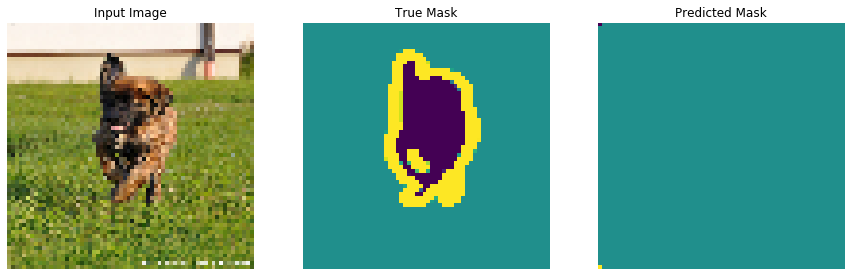

In [107]:
if num_classes == 3:
    show_predictions(test_dataset, model, num_of_pred=1)

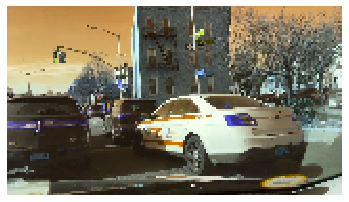

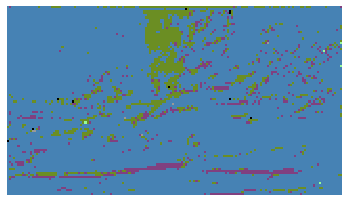

In [48]:
if num_classes == 20:
    n = 1
    pred = model.predict(x_test[n].reshape(1,90,160,3))
    res = np.argmax(pred, axis=3).reshape(90,160,1)
    img = ConvertToRGBImage(res)
    plt.imshow(x_test[n]+mean)
    plt.axis('off')
    plt.show()
    plt.imshow(img)
    plt.axis('off')
    plt.show()